## Домашнее задание
1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики


__Решение:__

Для начала построю график требуемой функции и зафиксирую ее две координаты (по условию задачи пространство двумерное):

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#%matplotlib nbagg
#%matplotlib notebook                   
# позволяет вертеть график


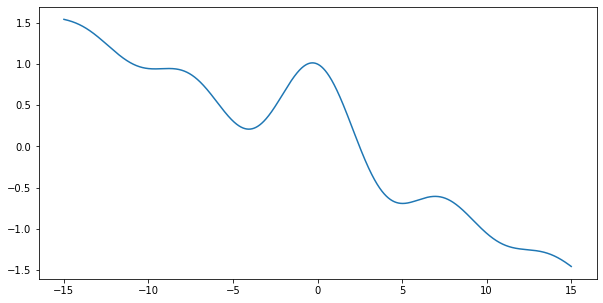

In [2]:
fig = plt.subplots(figsize=(10,5))

# берем 10 тыс иксов со значениями от -15 до 15
x = np.linspace(-15, 15,10000)

y = lambda x: (np.sin(x) / x) - (x/10) #- z
y_x = y(x) # чтобы каждый раз не считывать функцию

plt.plot(x, y(x))

plt.show()

In [3]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

Переведем точки с графика в тензоры:

In [4]:
train_data_length = 10000 # также 10 тыс. точек
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = torch.from_numpy(np.array(x))  # x
train_data[:, 1] = torch.from_numpy(np.array(y_x)) # x2 он же у

train_labels = torch.zeros(train_data_length)  # т.к. ган обучает без учителя метки могут быть любыми, делаю их т.к.  в даталоудер формально их надо подавать

train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]



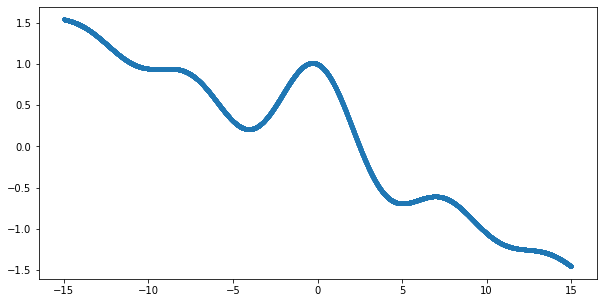

In [5]:
# пробую отрисовать тензорные точки

fig = plt.subplots(figsize=(10,5))

plt.plot(train_data[:, 0], train_data[:, 1], ".")

Теперь подаем тензоры в даталоудер:

In [6]:
batch_size = 25
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2))

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()
generator = Generator()


In [8]:
lr = 0.001
num_epochs = 100
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [9]:
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
      
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Выводим значения функций потерь
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}, Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.29269495606422424, Loss G.: 1.1707361936569214
Epoch: 10 Loss D.: 0.6402727365493774, Loss G.: 1.3281811475753784
Epoch: 20 Loss D.: 0.707195520401001, Loss G.: 0.7180039882659912
Epoch: 30 Loss D.: 0.6849612593650818, Loss G.: 0.7695886492729187
Epoch: 40 Loss D.: 0.6783706545829773, Loss G.: 0.7778949737548828
Epoch: 50 Loss D.: 0.6911923885345459, Loss G.: 0.7676090002059937
Epoch: 60 Loss D.: 0.6758281588554382, Loss G.: 0.7350113391876221
Epoch: 70 Loss D.: 0.6551417708396912, Loss G.: 0.7368075847625732
Epoch: 80 Loss D.: 0.6551101803779602, Loss G.: 0.7643318772315979
Epoch: 90 Loss D.: 0.706564724445343, Loss G.: 0.6891575455665588


In [10]:
latent_space_samples = torch.randn(1000, 2) # тыщу точек подам  в генератор чтобы график был более четче
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach() # detach(), чтобы получить необходимые данные из вычислительного графа PyTorch


Теперь отрисую рядом графики исходный и предсказаний ГАНа: 

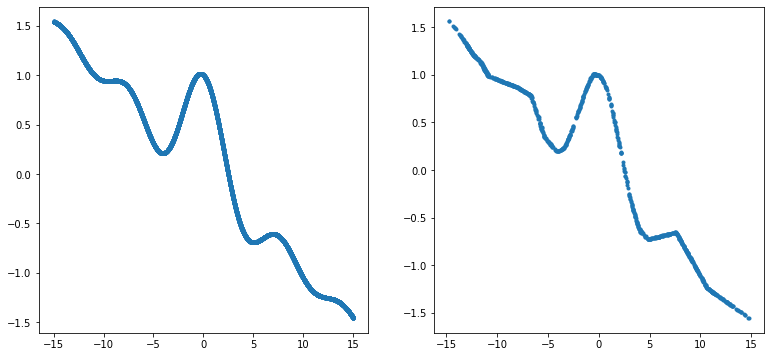

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(13, 6))
ax[0].plot(train_data[:, 0], train_data[:, 1], ".")
ax[1].plot(generated_samples[:, 0], generated_samples[:, 1], ".")
plt.show()

Вроде бы получилось неплохо.

__Попробую проделать то же самое, но для трехмерного графика:__

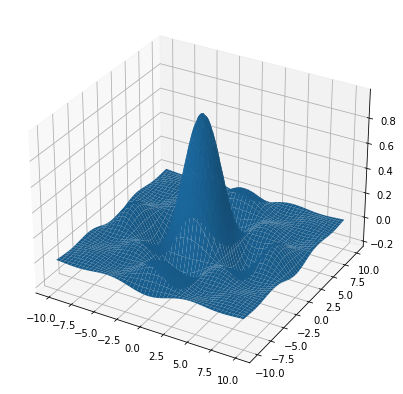

In [13]:
def makeData ():
    # Строим сетку в интервале от -10 до 10, имеющую 100 отсчетов по обоим координатам
    x = np.linspace (-10, 10, 10000)
    y = np.linspace (-10, 10, 10000)

    # Создаем двумерную матрицу-сетку
    xgrid, ygrid = np.meshgrid(x, y)

    # В узлах рассчитываем значение функции
    z = np.sin (xgrid) * np.sin (ygrid) / (xgrid * ygrid)
    return xgrid, ygrid, z



x, y, z = makeData()

fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(projection='3d')
axes.plot_surface(x[0], y, z) # в х получилось 10 тыс одинаковых списков с 10 тыс значениями, также и в y и z
plt.show()

In [14]:
train_data_length = 10000 # также 10 тыс. точек
train_data = torch.zeros((train_data_length, 3))
train_data[:, 0] = torch.from_numpy(np.array(x[0]))  # x
train_data[:, 1] = torch.from_numpy(np.array(y[0])) # x2 он же у
train_data[:, 2] = torch.from_numpy(np.array(z[0]))

train_labels = torch.zeros(train_data_length)  # т.к. ган обучает без учителя метки могут быть любыми, делаю их т.к.  в даталоудер формально их надо подавать

train_set = [(train_data[i], train_labels[i]) for i in range(train_data_length)]


batch_size = 50
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

In [15]:
# т.к. на вход идет уже 3 признака, то нужно переписать генератор и дискриминатор
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 256), # 3 - кол-во признаков
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid())

    def forward(self, x):
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 16), # 3 - кол-во признаков
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 3)) # 3 - кол-во признаков

    def forward(self, x):
        output = self.model(x)
        return output

discriminator = Discriminator()
generator = Generator()

# переопределяю оптимизаторы после того, как обнулил у генератора и дискриминатора веса
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [17]:
# заново обучаю ган на 200 эпохах
for epoch in range(200):
    for n, (real_samples, _) in enumerate(train_loader):
      
        # Данные для обучения дискриминатора
        real_samples_labels = torch.ones((batch_size, 1))
        latent_space_samples = torch.randn((batch_size, 3)) # 3 - кол-во признаков
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1))
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Данные для обучения генератора
        latent_space_samples = torch.randn((batch_size, 3)) # 3 - кол-во признаков

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Выводим значения функций потерь
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}, Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.6731923818588257, Loss G.: 0.7030125260353088
Epoch: 10 Loss D.: 0.26451200246810913, Loss G.: 3.480281352996826
Epoch: 20 Loss D.: 0.5676580667495728, Loss G.: 0.9430740475654602
Epoch: 30 Loss D.: 0.48592525720596313, Loss G.: 1.130333662033081
Epoch: 40 Loss D.: 0.5206820368766785, Loss G.: 0.9455308318138123
Epoch: 50 Loss D.: 0.4870394170284271, Loss G.: 1.1810393333435059
Epoch: 60 Loss D.: 0.4030377268791199, Loss G.: 2.4552125930786133
Epoch: 70 Loss D.: 0.5053825378417969, Loss G.: 1.683335304260254
Epoch: 80 Loss D.: 0.6411845684051514, Loss G.: 0.8292922973632812
Epoch: 90 Loss D.: 0.6578605771064758, Loss G.: 0.704539954662323
Epoch: 100 Loss D.: 0.5903844237327576, Loss G.: 1.5942736864089966
Epoch: 110 Loss D.: 0.7056394815444946, Loss G.: 0.8974851369857788
Epoch: 120 Loss D.: 0.5969703793525696, Loss G.: 0.9634284377098083
Epoch: 130 Loss D.: 0.5427059531211853, Loss G.: 0.987052857875824
Epoch: 140 Loss D.: 0.5955004692077637, Loss G.: 0.82906705141

In [18]:
latent_space_samples = torch.randn(1000, 3) # тыщу точек подам  в генератор чтобы график был более четче
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach() 

In [19]:
f = generated_samples.numpy()

In [20]:
f[:10]

array([[ 8.79535294e+00, -1.04576416e+01, -2.25660205e-03],
       [ 5.33958054e+00, -1.01683722e+01,  1.22262537e-02],
       [-3.40305710e+00, -1.00877752e+01,  1.63160264e-04],
       [ 3.70045376e+00, -1.01685333e+01,  1.00041628e-02],
       [ 4.69595671e+00, -1.01474838e+01,  1.44386888e-02],
       [-7.81597137e-01, -1.00727530e+01, -4.61620353e-02],
       [ 2.82749742e-01, -1.00605135e+01, -5.40158451e-02],
       [ 6.75788021e+00, -1.02155933e+01,  1.16711855e-03],
       [ 3.72857523e+00, -1.01603346e+01,  1.03521124e-02],
       [ 4.43959141e+00, -1.01162825e+01,  1.33064240e-02]], dtype=float32)

In [21]:
x1 , y1, z1 = [], [],[] 

for i in f:
  x1.append(i[0])
  y1.append(i[1])
  z1.append(i[2])

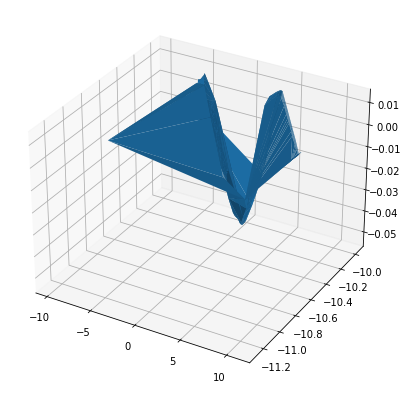

In [24]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(projection='3d')
axes.plot_trisurf(np.array(x1), np.array(y1), np.array(z1)) 
plt.show()

In [40]:
y2, z2 = [], []

for i in range(10000):
  z2.append(z1)
  y2.append(y1)


In [ ]:
y2

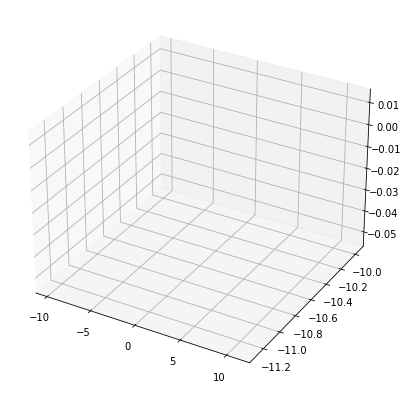

In [39]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(projection='3d')
axes.plot_surface(np.array(x1), np.array(y2), np.array(z2)) 
plt.show()

ValueError: ignored

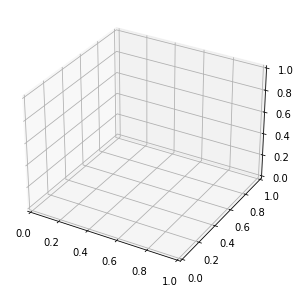

In [35]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_subplot(projection='3d')

axes.plot_surface(train_data[:, 0].numpy(), train_data[:, 1].numpy(),train_data[:, 2].numpy())


# fig = plt.figure(figsize=(7,7))
# axes = fig.add_subplot(projection='3d')
# axes.plot_surface(x[0], y, z) # в х получилось 10 тыс одинаковых списков с 10 тыс значениями, также и в y и z
# plt.show()